## 載入套件

In [1]:
import numpy as np
import pandas as pd
#from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
#from sklearn.model_selection import GridSearchCV
from sklearn.utils import parallel_backend
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from sklearn.metrics import roc_curve, roc_auc_score, auc
import seaborn as sns
import torch
#載入thundersvm(重要)
from thundersvm import SVC

C:\Users\asmmn\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 建立模型抓取資料

In [2]:
#建立模型
model = SVC(kernel='rbf')
#載入資料
df=pd.read_csv('Spam.csv')
#建立自變數資料(X)以便後面抓取自變數名稱
df_norm = df.drop('spam',axis=1)

## 觀看使否有遺缺值

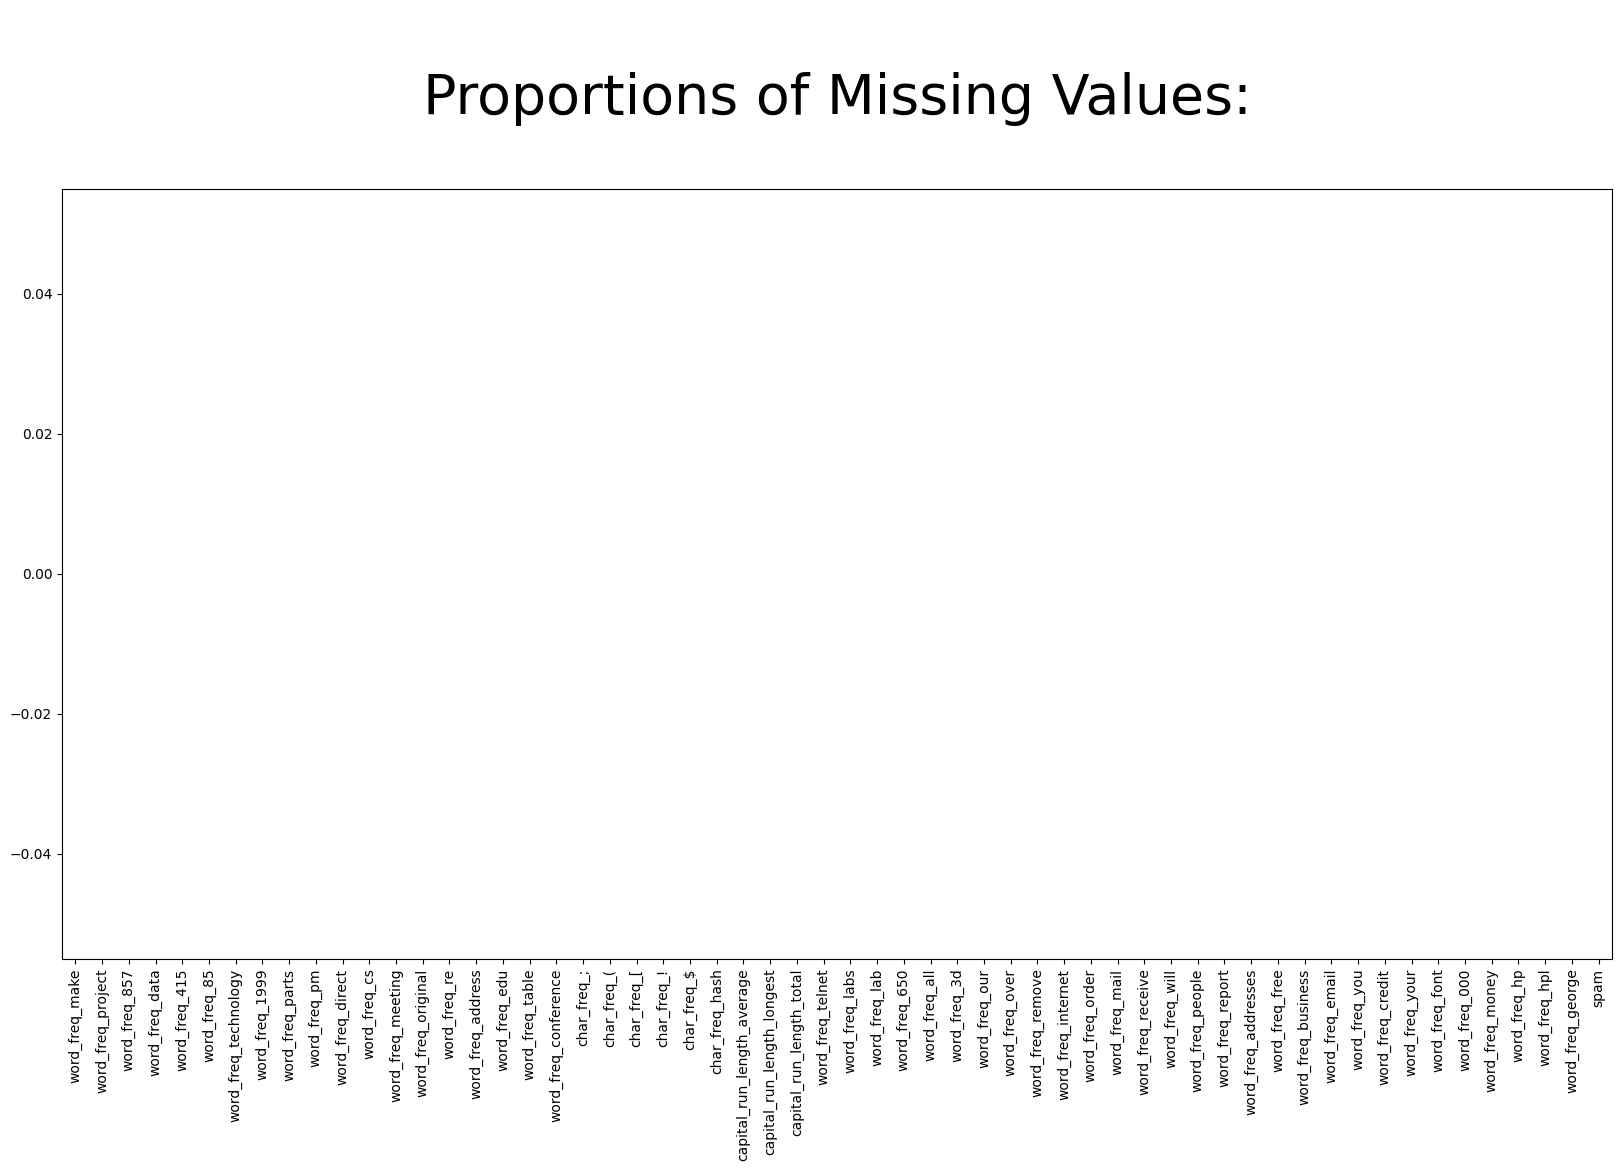

In [3]:
#展示遺缺值的比率(重要)
d=((df.isnull().sum()/df.shape[0])).sort_values(ascending=False)
#畫一張圖，大小為20x10
d.plot(kind='bar', figsize=(20,10))
plt.title("\nProportions of Missing Values:\n",fontsize=40)
plt.show()
#下圖所示本資料及非常乾淨沒有遺缺值所以不需要進行遺缺值處理

## 切割訓練集與測試集

In [4]:
#將類別變數轉換為數字(此資料集已為數字但為保存用留下這行)
# df['target']=df['spam'].apply(lambda x: 1 if x==1 else 0)
#切分訓練集與測試集
train,test=train_test_split(df,test_size=0.2,random_state=42)
#建立訓練集自變數(X)
train_data=train[[str(i) for i in df_norm.columns]]#列名
#建立訓練集應變數(X)
train_label=train['spam']
#建立測試集自變數(X)
test_data=test[[str(i) for i in df_norm.columns]]#列名
#建立訓練集應變數(X)
test_label=test['spam']

## 添加人工資料並訓練SVM模型

In [5]:
#在少數樣本位置人工合成樣本提升模型訓練成果(重要)
X_resampled, y_resampled = SMOTE().fit_resample(train_data, train_label)
#訓練模型
clf =model.fit(X_resampled, y_resampled )
#取得測試集預測值
y_pred_test = model.predict(test[[str(i) for i in df_norm.columns]])
#取得訓練集預測值
y_pred_train = model.predict(train[[str(i) for i in df_norm.columns]])

## 訓練集結果評估(重要)

In [6]:
#以訓練集計算準確率
accuracy = model.score(X_resampled, y_resampled)
print(accuracy)

0.9530350022153301


C:\Users\asmmn\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


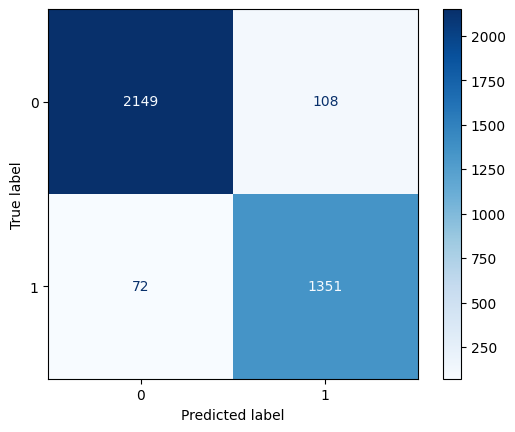

In [7]:
#畫出訓練集混淆矩陣
cm = plot_confusion_matrix(
    model,
    train_data, train_label,
    cmap=plt.cm.Blues
)
plt.show()

In [8]:
#以測試集進行模型評估
print(classification_report(train['spam'],y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2257
           1       0.93      0.95      0.94      1423

    accuracy                           0.95      3680
   macro avg       0.95      0.95      0.95      3680
weighted avg       0.95      0.95      0.95      3680



## 測試集訓練結果(重要)

In [9]:
#以測試集進行模型評估
print(classification_report(test['spam'],y_pred_test))
#以測試集計算準確率
accuracy = model.score(test_data, test_label)
print(accuracy)

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       531
           1       0.76      0.88      0.81       390

    accuracy                           0.83       921
   macro avg       0.83      0.84      0.83       921
weighted avg       0.84      0.83      0.83       921

0.8306188925081434


<AxesSubplot:>

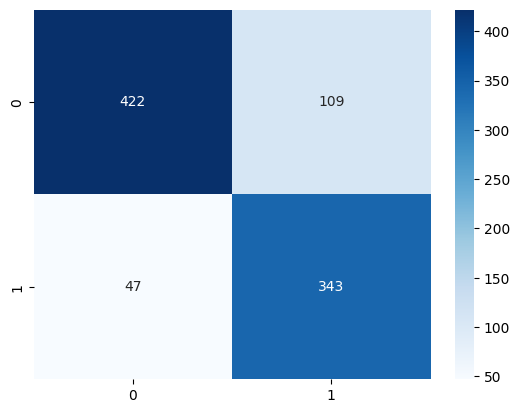

In [10]:
class_names = ["spam","normal"]
#畫出測試集混淆矩陣
cf_matrix = confusion_matrix(test['spam'], y_pred_test)
sns.heatmap(cf_matrix, annot=True,fmt="d",cmap='Blues')

In [11]:
#計算訓練集應變數(Y)預測機率
y_score_train = model.decision_function(X_resampled)
#使用訓練集實際結果與預測機率計算動態FPR、TPR與閥值
train_fpr, train_tpr, tr_thresholds = roc_curve(y_resampled, y_score_train)
#計算測試集應變數(Y)預測機率
y_score_test = model.decision_function(test_data)
#使用測試集實際結果與預測機率計算動態FPR、TPR與閥值
test_fpr, test_tpr, te_thresholds = roc_curve(test['spam'], y_score_test)

## ROC曲線圖與AUC值(重要)

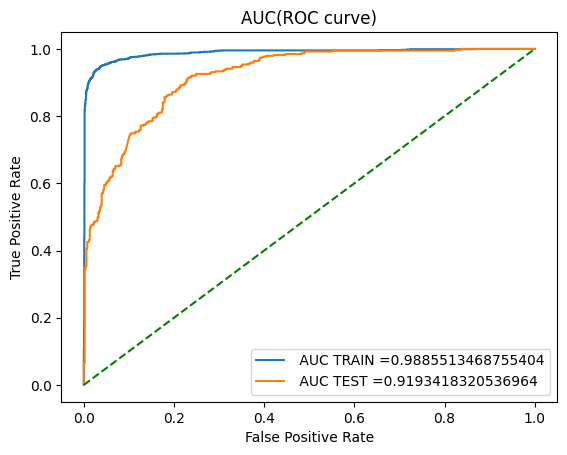

In [12]:
#畫出訓練集與測試集的ROC曲線圖 AUC值越大代表模型性能越好
plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()